In [1]:
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader

In [2]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import  EarlyStopping,ModelCheckpoint
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web

In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
IT_Companies_names = [ 'AAPL', 'AMZN', 'GOOG', 'FB', 'MSFT',  'HPQ', 'NVDA','NFLX', 'CSCO', 'ADBE', 'IBM', 'TSLA']

In [5]:
def getData(start, end):
  IT_Companies=[]
  IT_Companies.append(web.DataReader('AAPL', 'yahoo', start=start, end=end))  
  IT_Companies.append(web.DataReader('AMZN', 'yahoo', start=start, end=end))
  IT_Companies.append(web.DataReader('GOOG', 'yahoo', start=start, end=end))
  IT_Companies.append(web.DataReader('FB', 'yahoo', start=start, end=end))
  IT_Companies.append(web.DataReader('MSFT', 'yahoo', start=start, end=end))
  IT_Companies.append(web.DataReader('HPQ', 'yahoo', start=start, end=end)) 
  IT_Companies.append(web.DataReader('NVDA', 'yahoo', start=start, end=end)) 
  IT_Companies.append(web.DataReader('NFLX', 'yahoo', start=start, end=end))
  IT_Companies.append(web.DataReader('CSCO', 'yahoo', start=start, end=end))
  IT_Companies.append(web.DataReader('ADBE', 'yahoo', start=start, end=end)) 
  IT_Companies.append(web.DataReader('IBM', 'yahoo', start=start, end=end))
  IT_Companies.append(web.DataReader('TSLA', 'yahoo', start=start, end=end))
  return IT_Companies

In [6]:
start='2010-01-01'
end='2021-12-31'
IT_Companies=getData(start, end)

In [7]:
for i in range(len(IT_Companies)):
  print(IT_Companies_names[i])
  print(IT_Companies[i])

AAPL
                  High         Low  ...       Volume   Adj Close
Date                                ...                         
2010-01-04    7.660714    7.585000  ...  493729600.0    6.553026
2010-01-05    7.699643    7.616071  ...  601904800.0    6.564355
2010-01-06    7.686786    7.526786  ...  552160000.0    6.459941
2010-01-07    7.571429    7.466071  ...  477131200.0    6.447999
2010-01-08    7.571429    7.466429  ...  447610800.0    6.490866
...                ...         ...  ...          ...         ...
2021-12-27  180.419998  177.070007  ...   74919600.0  180.330002
2021-12-28  181.330002  178.529999  ...   79144300.0  179.289993
2021-12-29  180.630005  178.139999  ...   62348900.0  179.380005
2021-12-30  180.570007  178.089996  ...   59773000.0  178.199997
2021-12-31  179.229996  177.259995  ...   64025500.0  177.570007

[3021 rows x 6 columns]
AMZN
                   High          Low  ...    Volume    Adj Close
Date                                  ...              

In [8]:
for i in range(len(IT_Companies)):
  IT_Companies[i]['Close_Average']=IT_Companies[i]['Close']
  IT_Companies[i] = IT_Companies[i]['Close_Average'].asfreq('D')
  #filling missing data for certain days 
  IT_Companies[i]=IT_Companies[i].fillna(method='ffill')

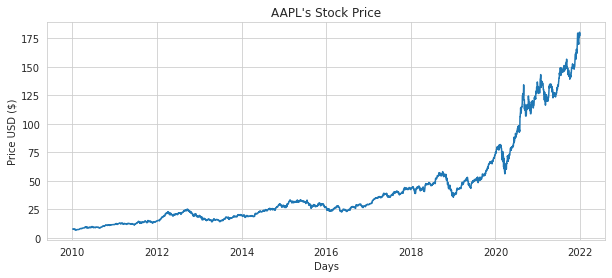

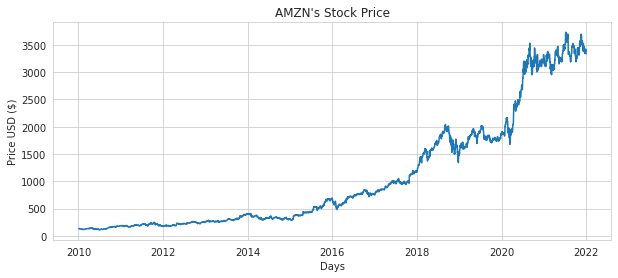

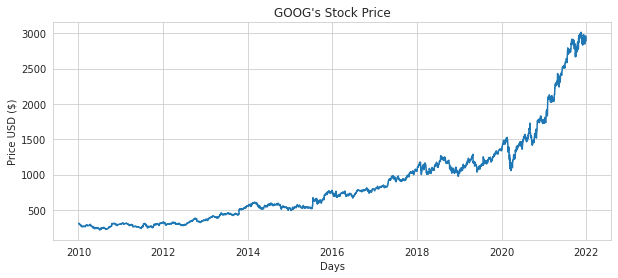

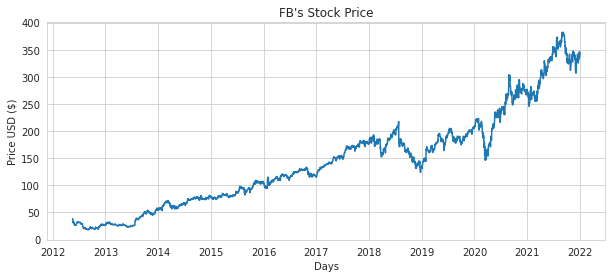

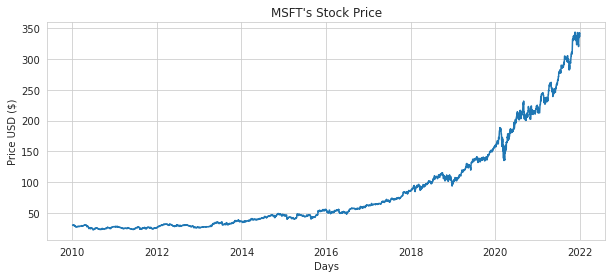

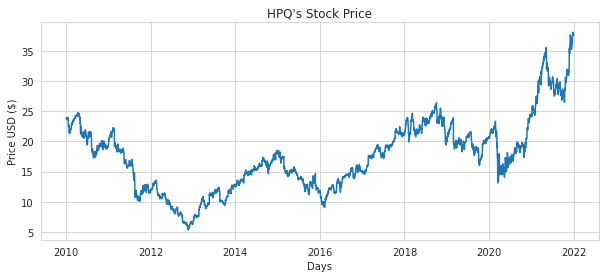

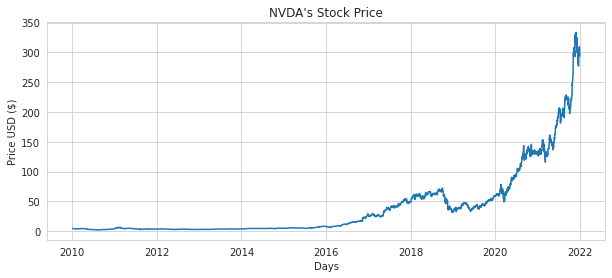

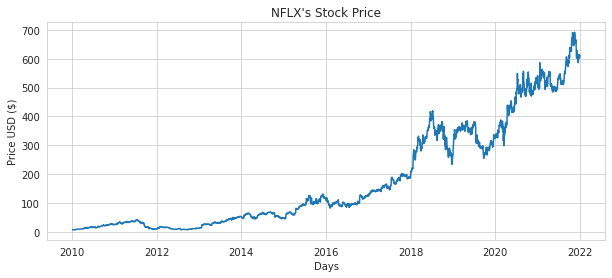

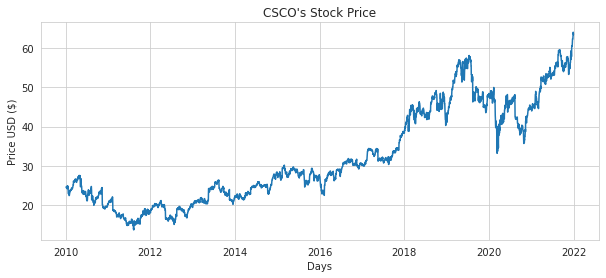

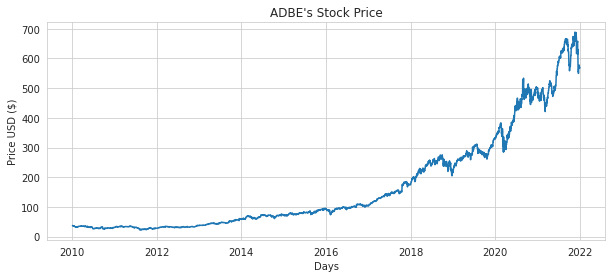

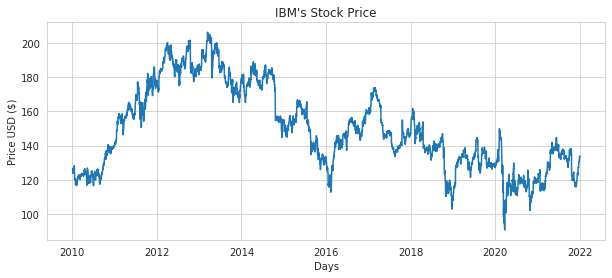

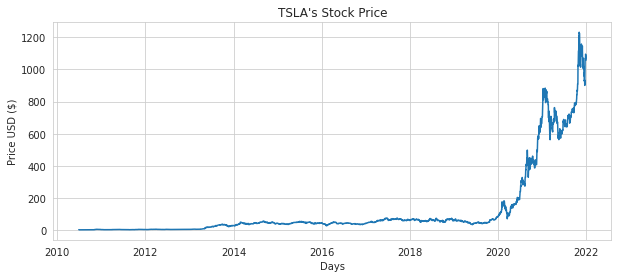

In [9]:
for i in range (len(IT_Companies)):
  #Visualize the close price Data
  plt.figure(figsize=(10, 4))
  plt.title(IT_Companies_names[i]+"'s Stock Price")
  plt.xlabel("Days")
  plt.ylabel("Price USD ($)")
  plt.plot(IT_Companies[i])
  plt.show()

In [10]:
#Preprocessing
IT_Companies_scaled=[]
scalers=[]
for i in range(len(IT_Companies)):
  scalers.append(MinMaxScaler())
  IT_Companies_scaled.append(pd.Series(scalers[i].fit_transform(IT_Companies[i].values.reshape(-1,1)).squeeze(), index=IT_Companies[i].index))

In [11]:
# Generating recurrent sequences from our time series
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i:n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [12]:
# We apply this function to the rescaled stock index for
window_size =63
X=[]
y=[]
for i in range(len(IT_Companies)):
  t1, t2 = create_univariate_rnn_data(IT_Companies_scaled[i], window_size=window_size)
  X.append(t1)
  y.append(t2)

In [13]:
X_train=[]
y_train=[]
X_test=[]
y_test=[]
X_val=[]
y_val=[]
for i in range(len(IT_Companies)):
  # Train
  X_train.append( X[i]['2010-01-01':'2020-09-30'].values.reshape(-1, window_size, 1))
  y_train.append(y[i]['2010-01-01':'2020-09-30'])
  # Validation
  X_val.append(X[i]['2020-10-01':'2020-12-31'].values.reshape(-1, window_size, 1))
  y_val.append(y[i]['2020-10-01':'2020-12-31'])
  #Test
  X_test.append(X[i]['2021-01-01':'2021-12-31'].values.reshape(-1, window_size, 1))
  y_test.append(y[i]['2021-01-01':'2021-12-31'])

In [14]:
n_obs, window_size, n_features = X_train[0].shape

In [15]:
# Define the Model Architecture
rnn=[]
for i in range(len(IT_Companies)):
  rnn.append(Sequential([
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
      Dense(1, name='Output')
  ]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


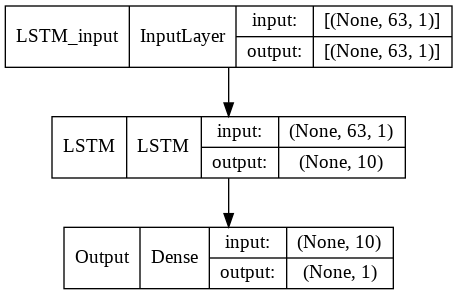

In [16]:
rnn[0].summary()
plot_model(rnn[i], show_shapes=True, show_layer_names=True)

In [17]:
# Train the Model
lstm_training=[]
for i in range(len(IT_Companies)):
  early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)
  rnn[i].compile(loss='mean_absolute_error', 
            optimizer='adam')
  lstm_training.append(rnn[i].fit(X_train[i],
                          y_train[i],
                          epochs=70,
                          batch_size=32,
                          shuffle=False,
                          validation_data=(X_val[i], y_val[i]),
                          callbacks=[early_stopping],
                          verbose=1))


Epoch 1/70
121/121 [==============================] - 5s 27ms/step - loss: 0.0237 - val_loss: 0.0294
Epoch 2/70
121/121 [==============================] - 3s 23ms/step - loss: 0.0360 - val_loss: 0.0154
Epoch 3/70
121/121 [==============================] - 3s 23ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 4/70
121/121 [==============================] - 3s 23ms/step - loss: 0.0121 - val_loss: 0.0160
Epoch 5/70
121/121 [==============================] - 3s 24ms/step - loss: 0.0109 - val_loss: 0.0151
Epoch 6/70
121/121 [==============================] - 3s 23ms/step - loss: 0.0101 - val_loss: 0.0161
Epoch 7/70
121/121 [==============================] - 3s 23ms/step - loss: 0.0090 - val_loss: 0.0173
Epoch 8/70
121/121 [==============================] - 3s 23ms/step - loss: 0.0081 - val_loss: 0.0161
Epoch 9/70
121/121 [==============================] - 3s 23ms/step - loss: 0.0080 - val_loss: 0.0172
Epoch 10/70
121/121 [==============================] - 3s 23ms/step - loss: 0.0076 - val_lo

In [18]:
train_predict_scaled=[]
test_predict_scaled=[]
val_predict_scaled=[]
for i in range(len(IT_Companies)):
  train_predict_scaled.append(rnn[i].predict(X_train[i]))
  test_predict_scaled.append(rnn[i].predict(X_test[i]))
  val_predict_scaled.append(rnn[i].predict(X_val[i]))

In [19]:
train_predict=[]
test_predict=[]
val_predict= []
for i in range(len(IT_Companies)):
  train_predict.append(pd.Series(scalers[i].inverse_transform(train_predict_scaled[i]).squeeze(), index=y_train[i].index))
  test_predict.append(pd.Series(scalers[i].inverse_transform(test_predict_scaled[i]).squeeze(), index=y_test[i].index))
  val_predict.append(pd.Series(scalers[i].inverse_transform(val_predict_scaled[i]).squeeze(), index=y_val[i].index))

In [20]:
# Rescale predictions 
y_train_rescaled =[]
y_test_rescaled =[]
y_val_rescaled =[]
for i in range(len(IT_Companies)):
  y_train_rescaled.append(scalers[i].inverse_transform(y_train[i].to_frame()).squeeze())
  y_test_rescaled.append(scalers[i].inverse_transform(y_test[i].to_frame()).squeeze())
  y_val_rescaled.append(scalers[i].inverse_transform(y_val[i].to_frame()).squeeze())

In [21]:
test_rmse=[]
test_mae=[]
for i in range(len(IT_Companies)):
  test_rmse.append(np.sqrt(mean_squared_error(test_predict[i], y_test_rescaled[i])))
  test_mae.append(mean_absolute_error(test_predict[i], y_test_rescaled[i]))

In [22]:
df= pd.DataFrame({'mae':test_mae, 'rmse': test_rmse}, index=IT_Companies_names)

cm = sns.light_palette("green", as_cmap=True)

df.style.background_gradient(cmap=cm).set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  """


,mae,rmse
AAPL,1.52,2.13
AMZN,33.55,45.85
GOOG,31.39,39.31
FB,8.63,10.54
MSFT,7.86,10.07
HPQ,1.81,1.97
NVDA,3.48,5.72
NFLX,7.41,10.58
CSCO,3.03,3.47
ADBE,7.82,10.76


In [23]:
ITPlot = []
for i in range(len(IT_Companies)):
  ITPlot.append(pd.concat([train_predict[i], val_predict[i],test_predict[i]]))
  ITPlot[i]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

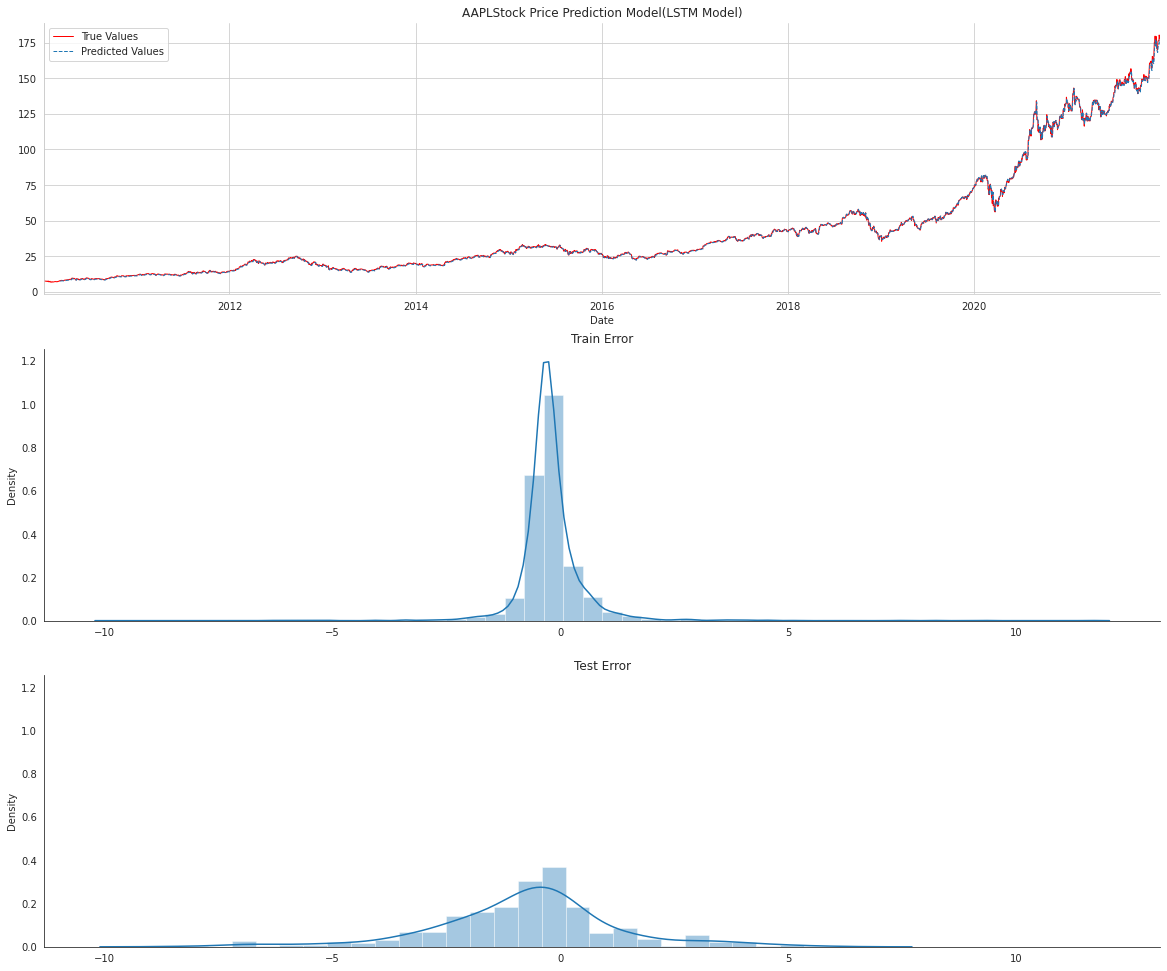

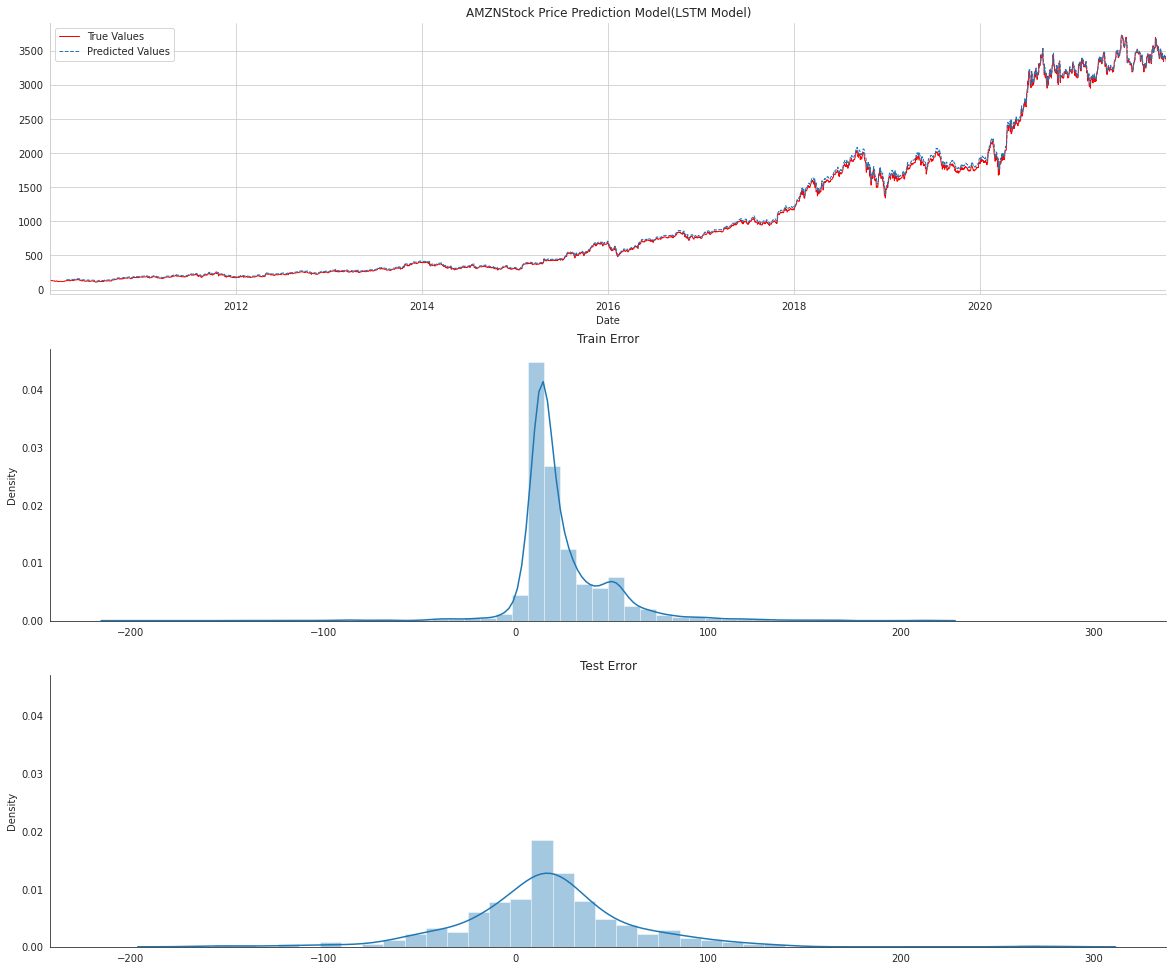

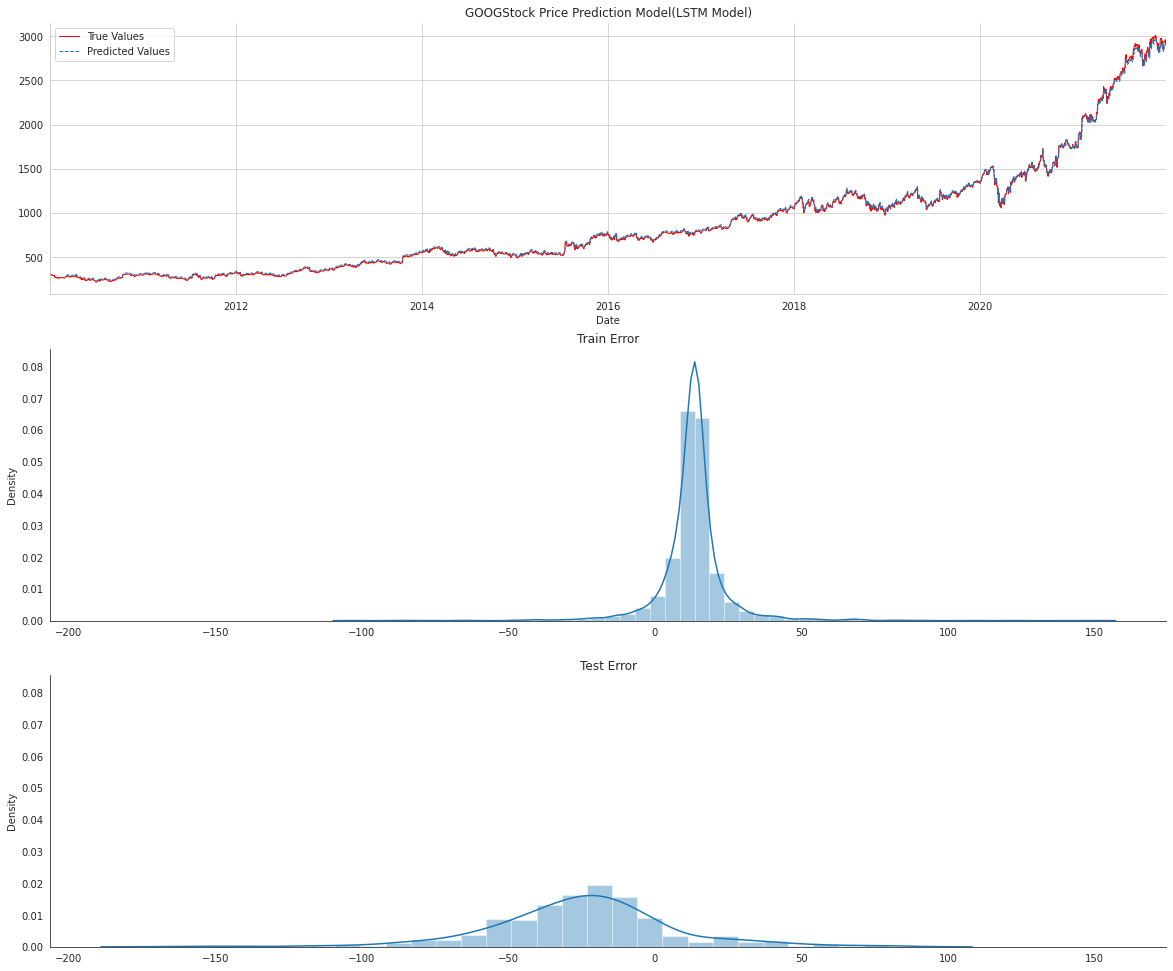

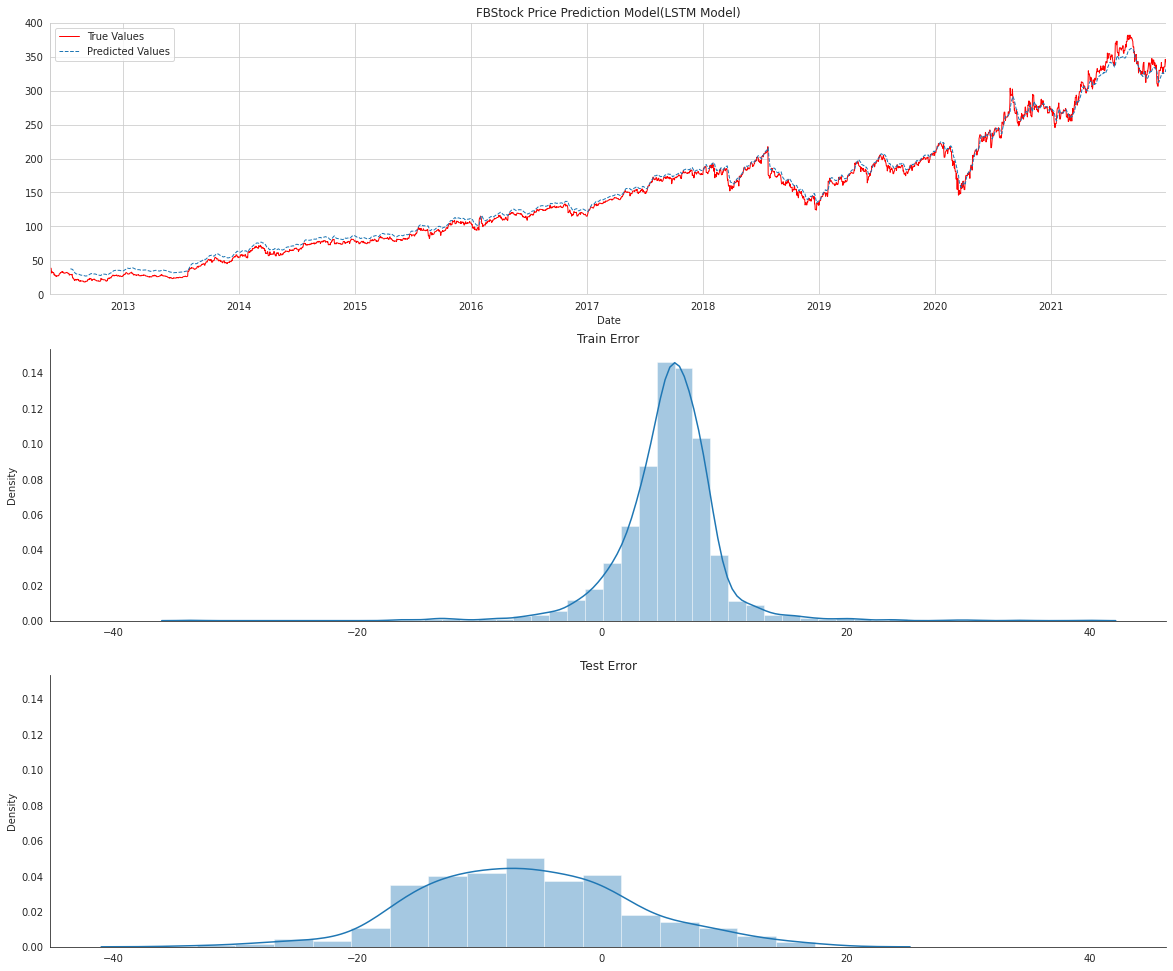

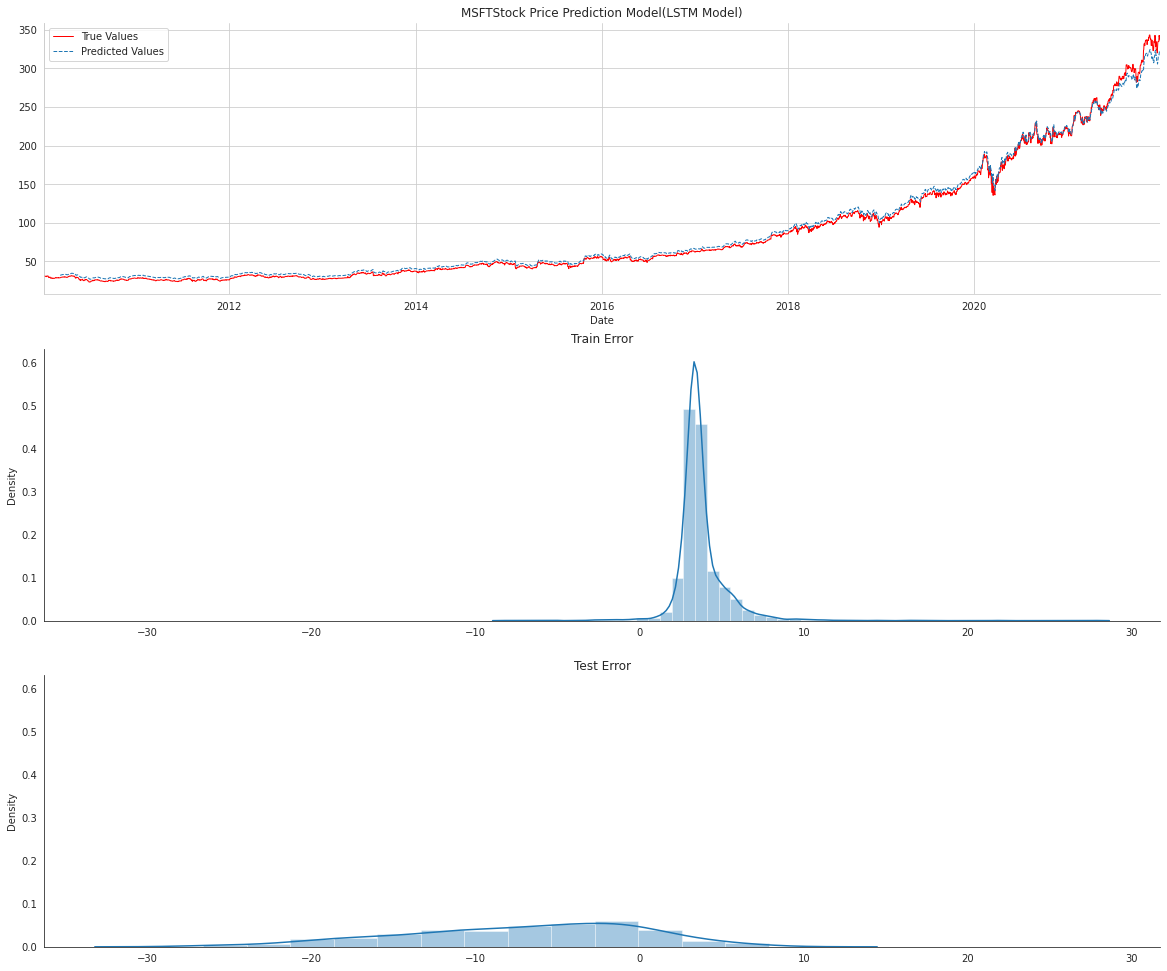

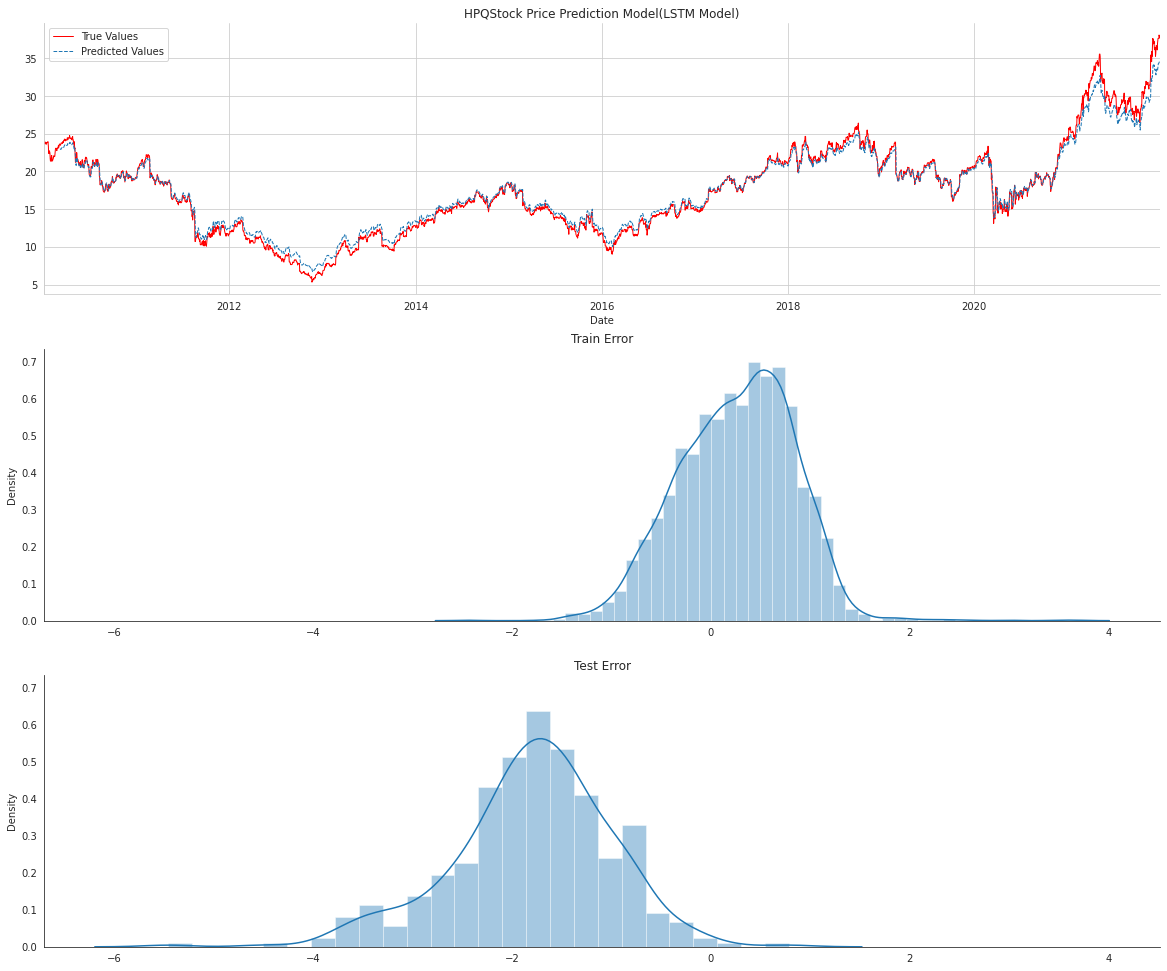

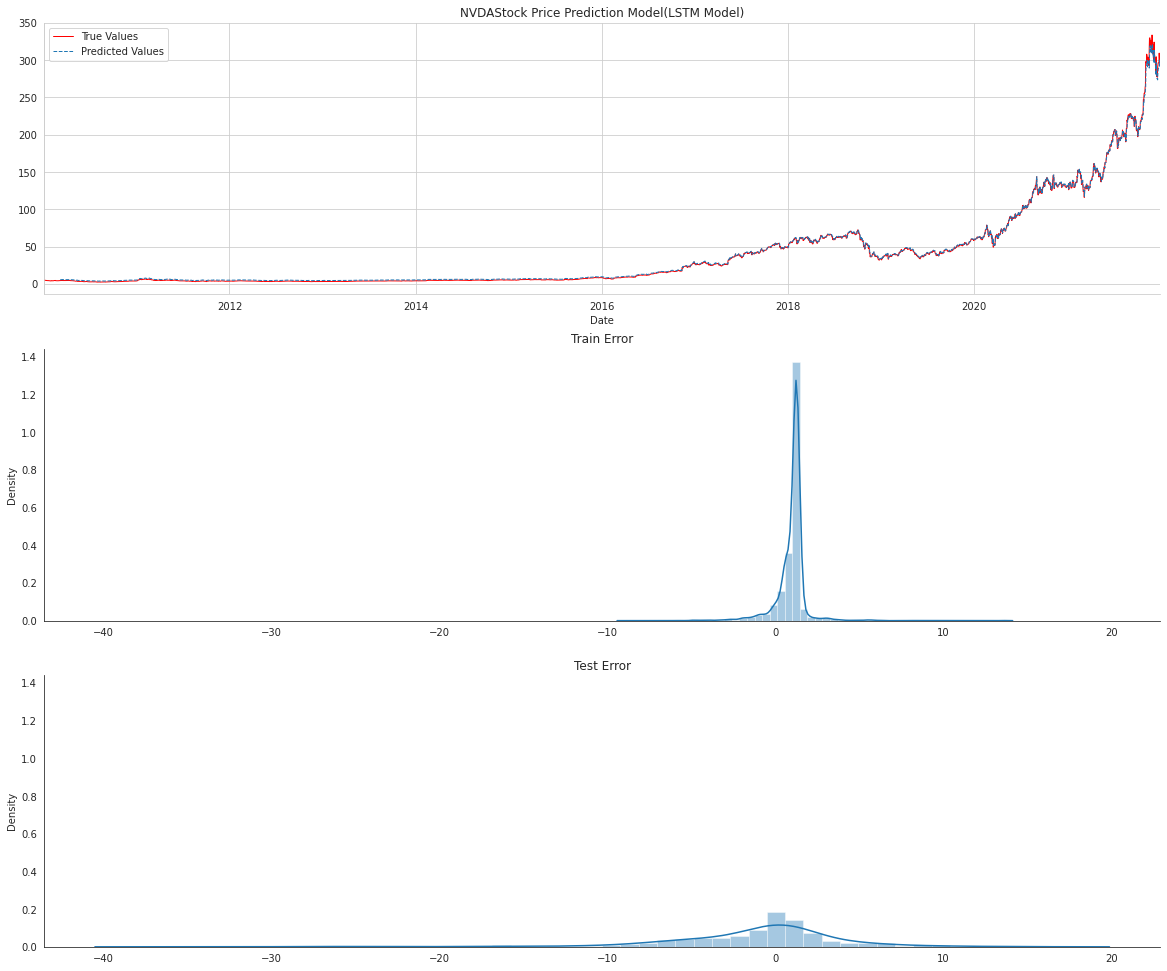

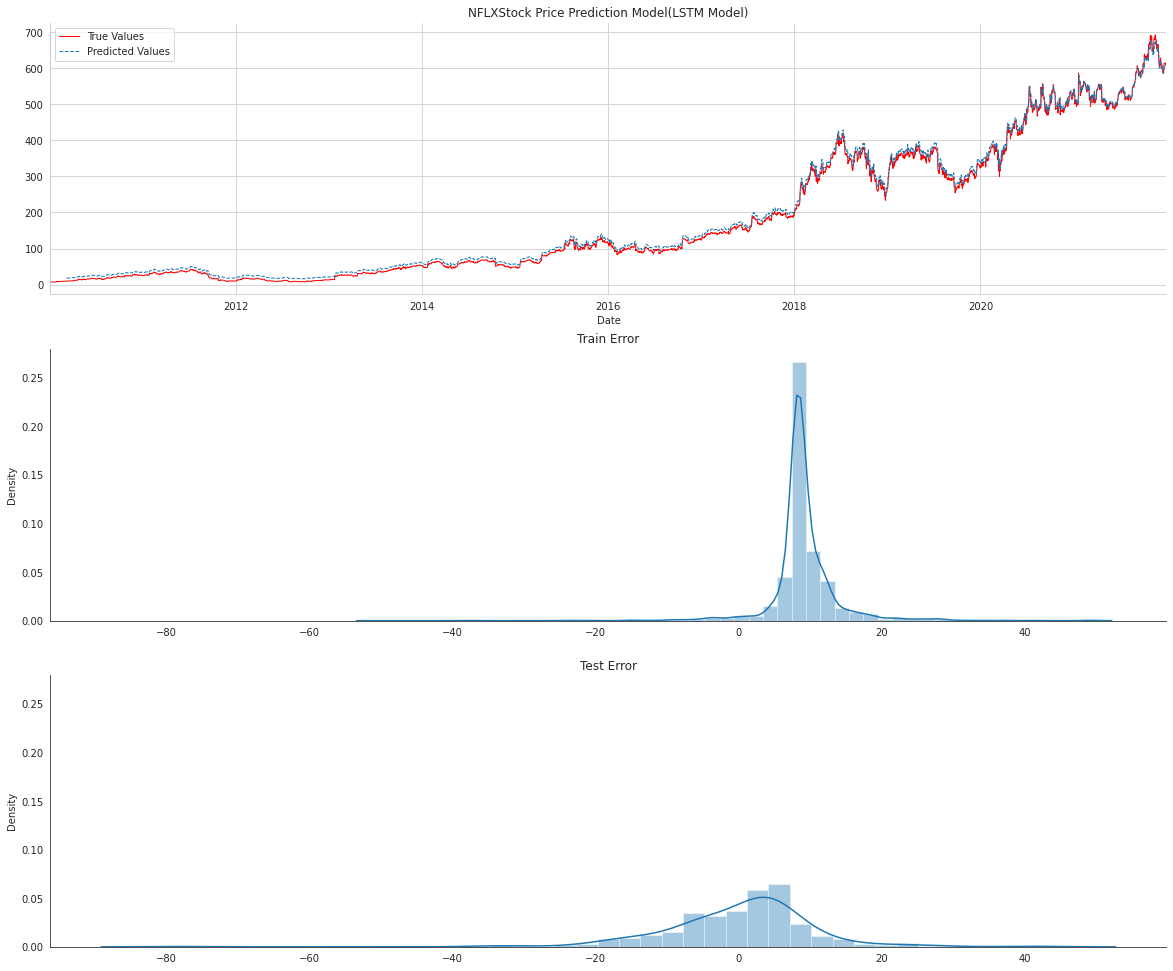

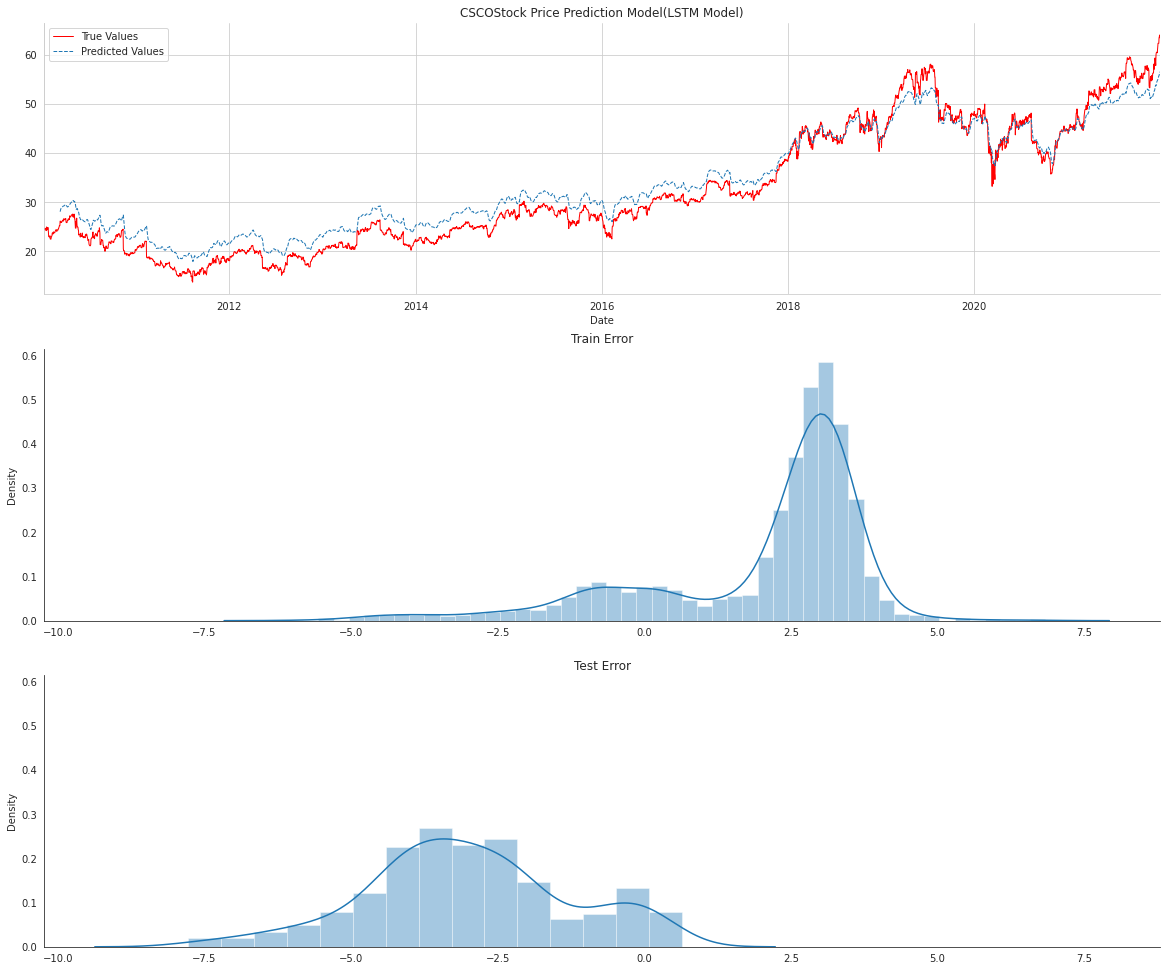

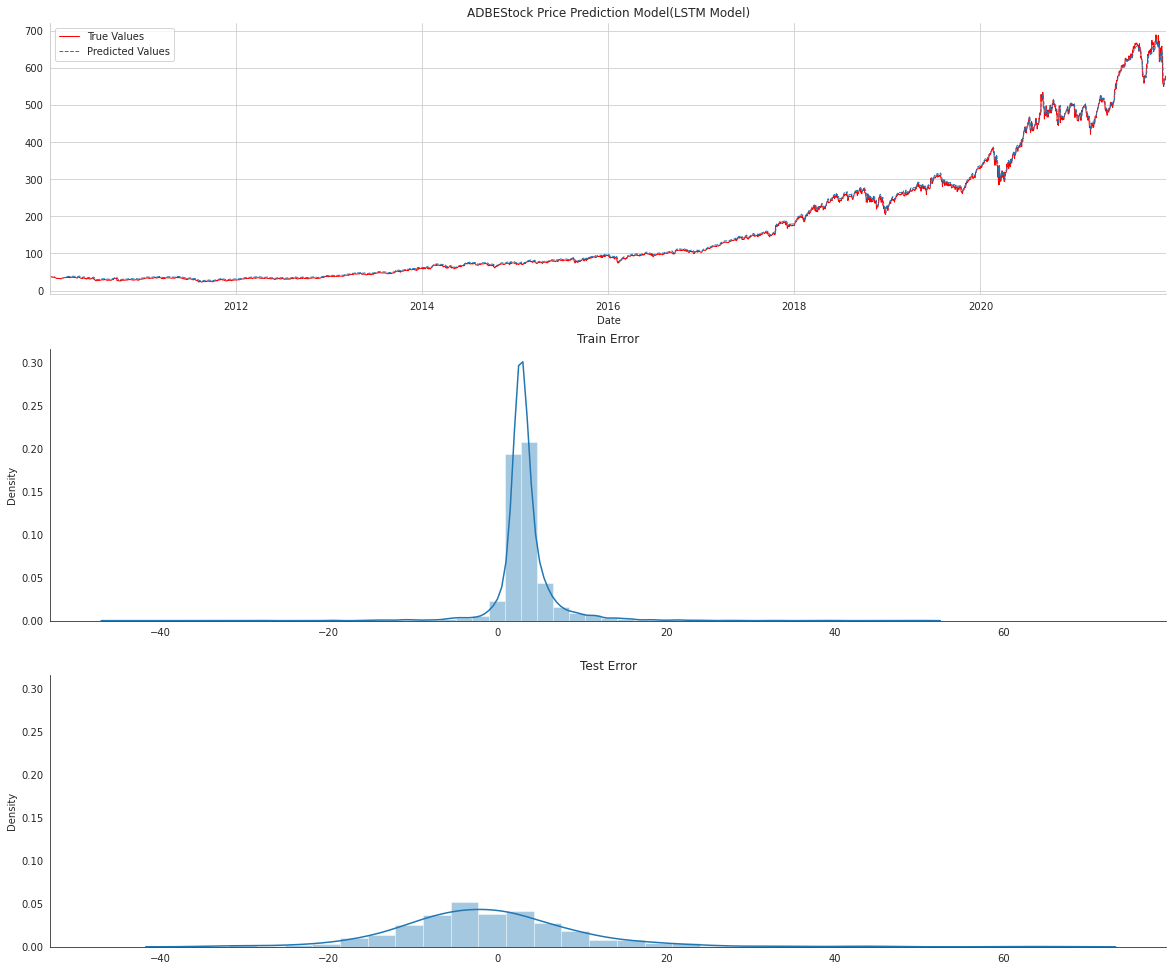

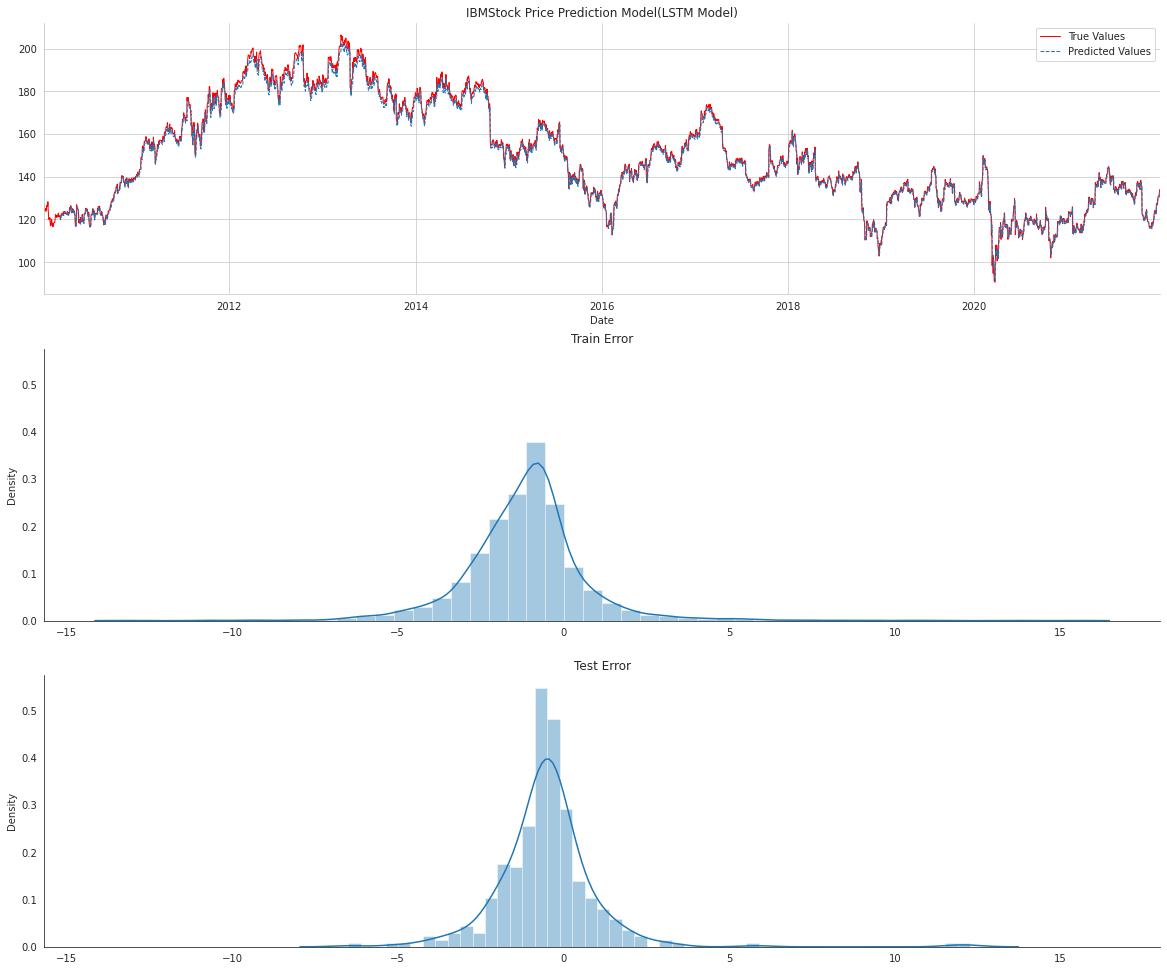

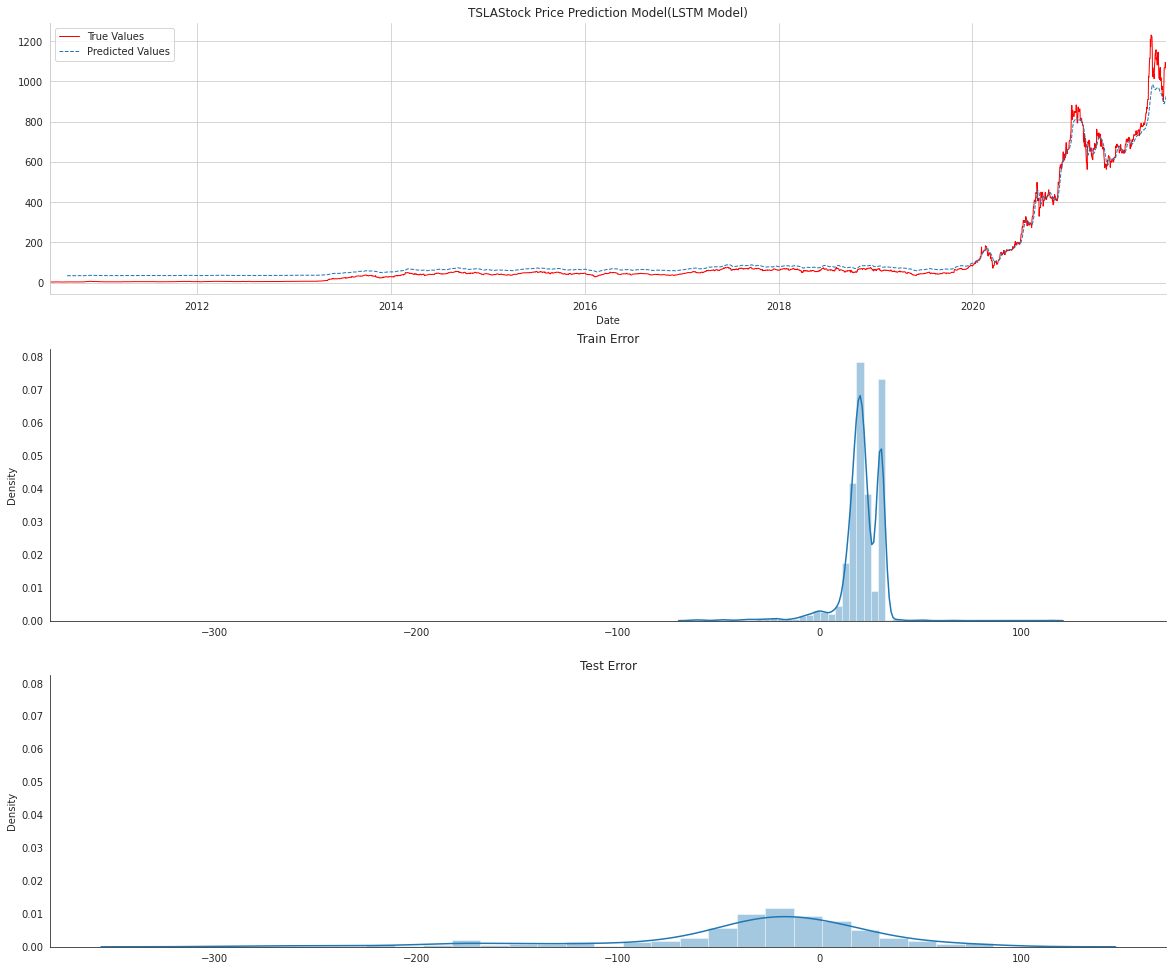

In [24]:
for i in range(len(IT_Companies)):
  fig=plt.figure(figsize=(20,17))
  ax1 = plt.subplot(311)
  IT_Companies[i].plot(lw=1, ax=ax1, c='r')
  ITPlot[i].plot(lw=1, ax=ax1, ls='--')
  plt.legend(["True Values", "Predicted Values"])
  ax1.set_title(IT_Companies_names[i]+'Stock Price Prediction Model(LSTM Model)')
  with sns.axes_style("white"):
      ax2 = plt.subplot(312)
      ax4 = plt.subplot(313, sharex = ax2, sharey=ax2)
      sns.distplot(train_predict[i].squeeze()- y_train_rescaled[i], ax=ax2)
      ax2.set_title('Train Error')
      sns.distplot(test_predict[i].squeeze()-y_test_rescaled[i], ax=ax4)
      ax4.set_title('Test Error')
  sns.despine()

In [25]:
k={}
s={}
for i in range(len(IT_Companies)):
  t=test_predict[i].squeeze()-y_test_rescaled[i]
  k[IT_Companies_names[i]]=t.kurtosis()
  s[IT_Companies_names[i]]=t.skew()

<BarContainer object of 12 artists>

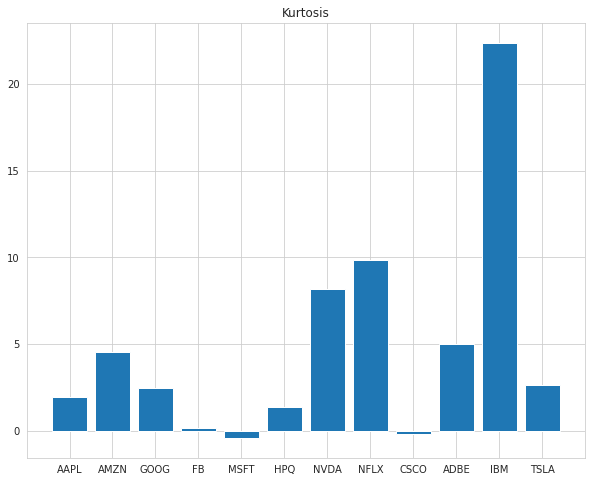

In [26]:
plt.figure(figsize=(10, 8))
plt.title("Kurtosis")
plt.bar(k.keys(),k.values())

<BarContainer object of 12 artists>

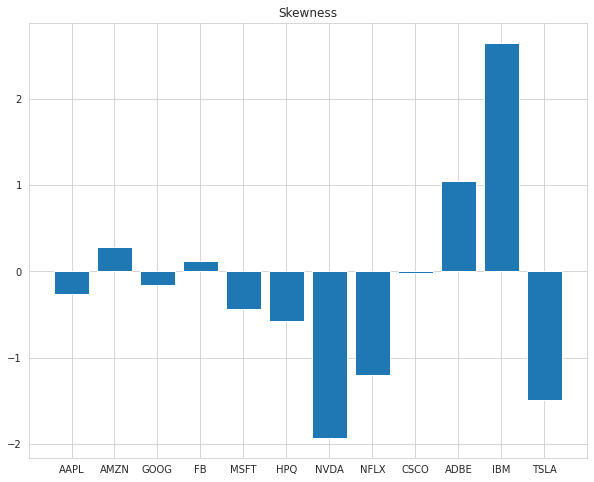

In [27]:
plt.figure(figsize=(10, 8))
plt.title("Skewness")
plt.bar(s.keys(),s.values())

In [28]:
#prediction for next 7 days
start = '2021-12-31'
last_output_arr=[[] for k in range(len(IT_Companies))]
future_days=7
for i in range (len(IT_Companies)):
  j=0
  B=np.append(X_test[i][-1],y_test[i][-1])
  B=B[1:]
  while j<future_days:
    B=B.reshape(1,63,1)
    yhat = rnn[i].predict(B,verbose=0)
    last_output_arr[i].append(yhat)
    B=B.reshape(63,1)
    B=np.append(B[1:],yhat)
    j=j+1
  last_output_arr[i] = np.array(last_output_arr[i])
  last_output_arr[i]=last_output_arr[i].reshape(future_days,1)

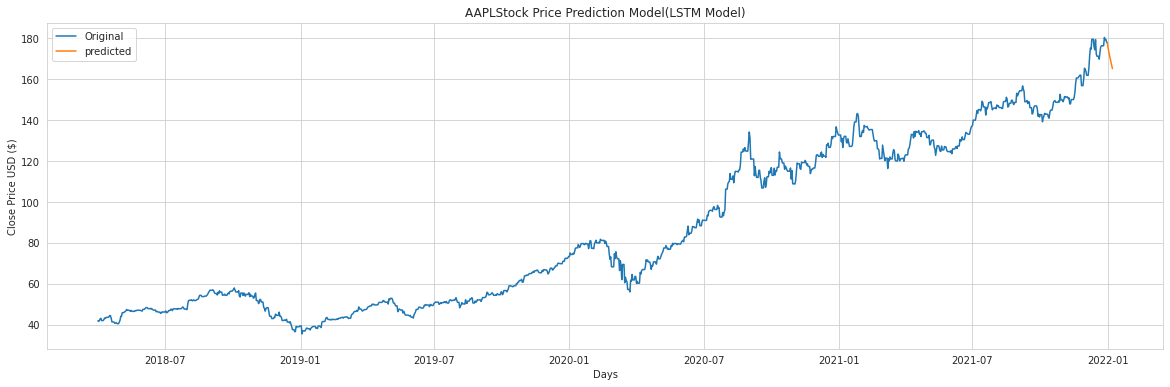

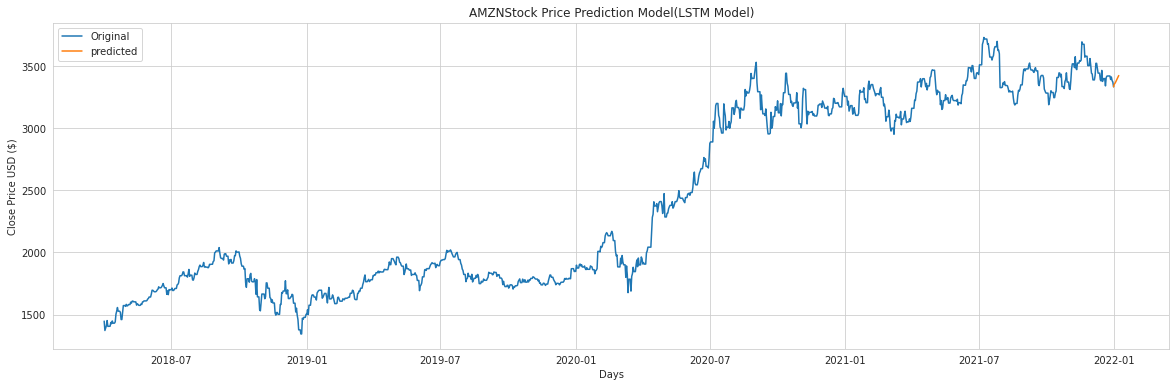

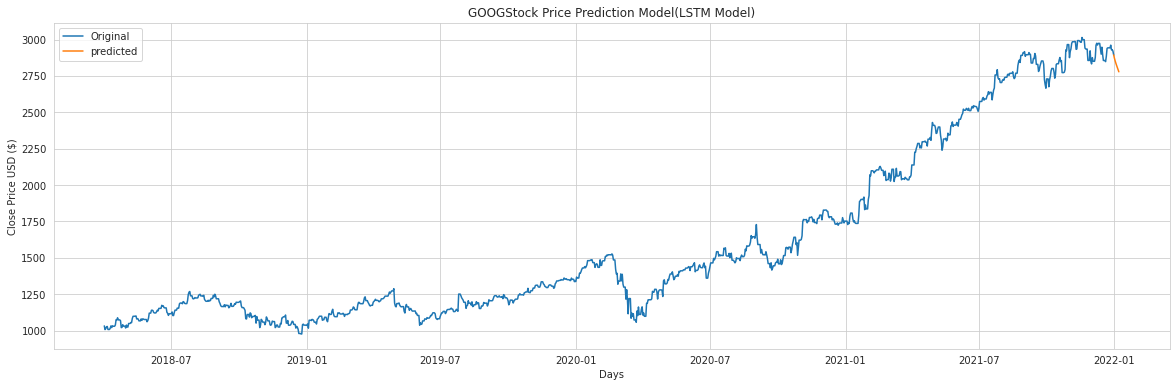

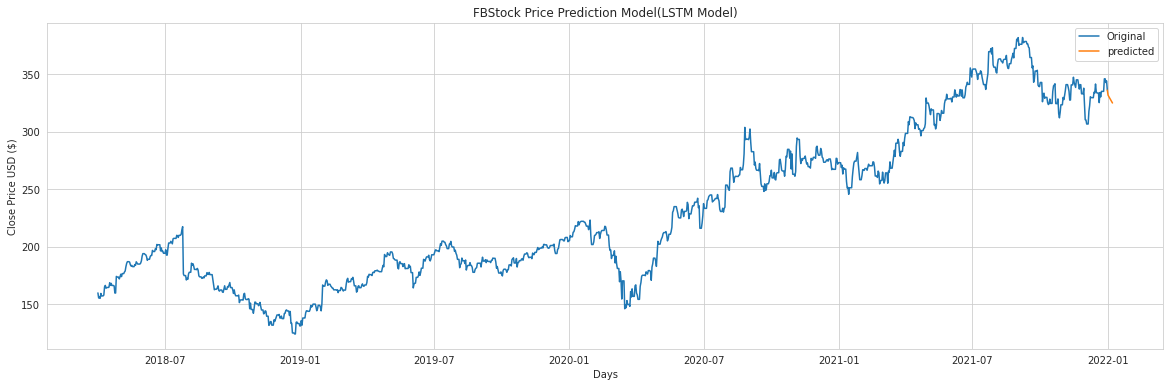

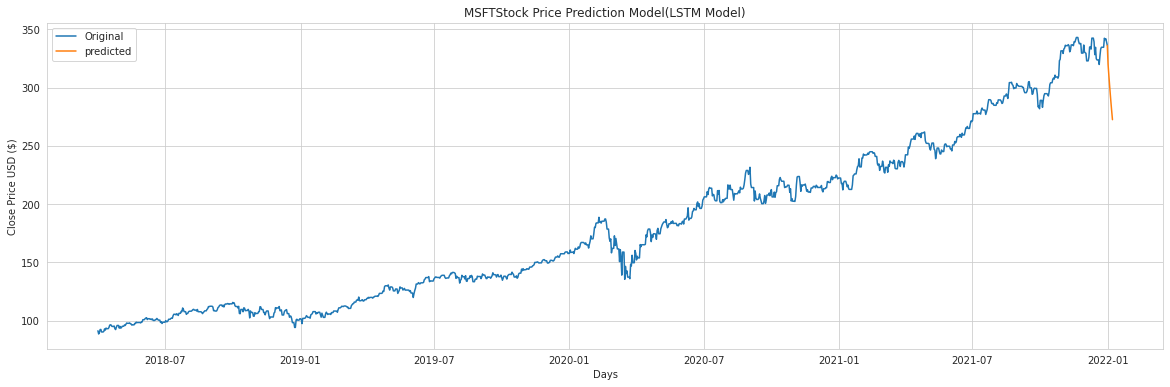

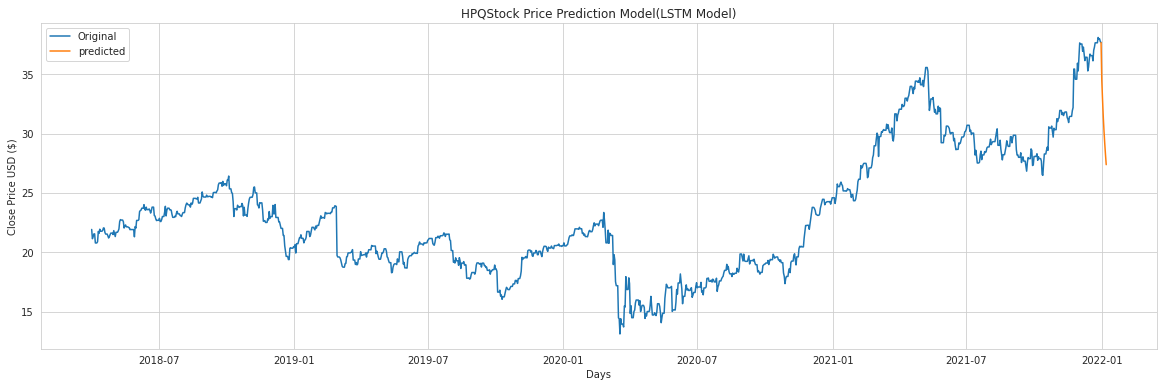

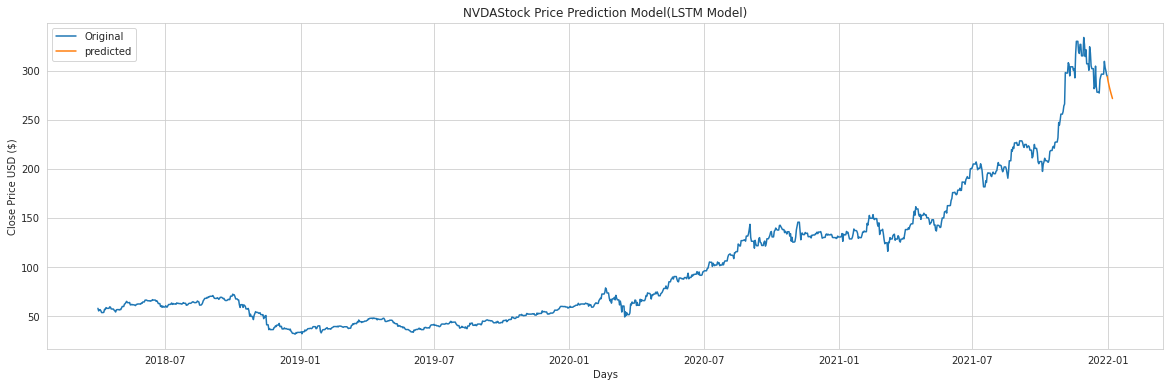

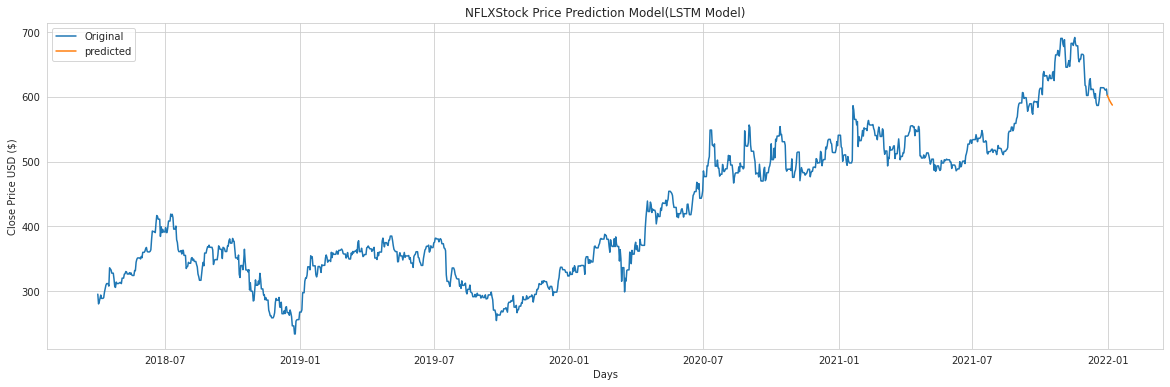

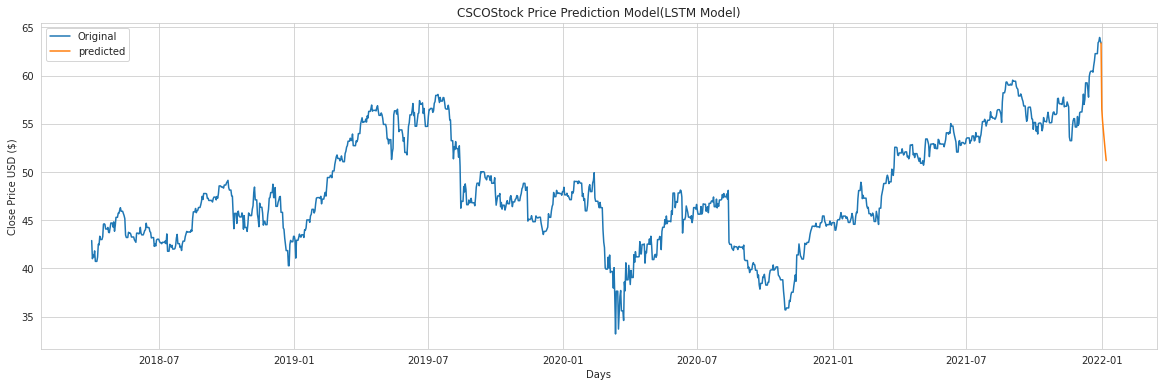

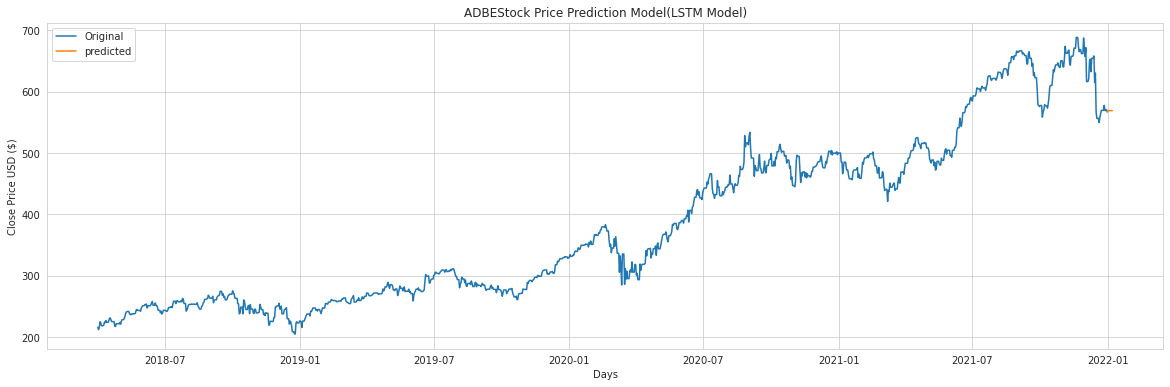

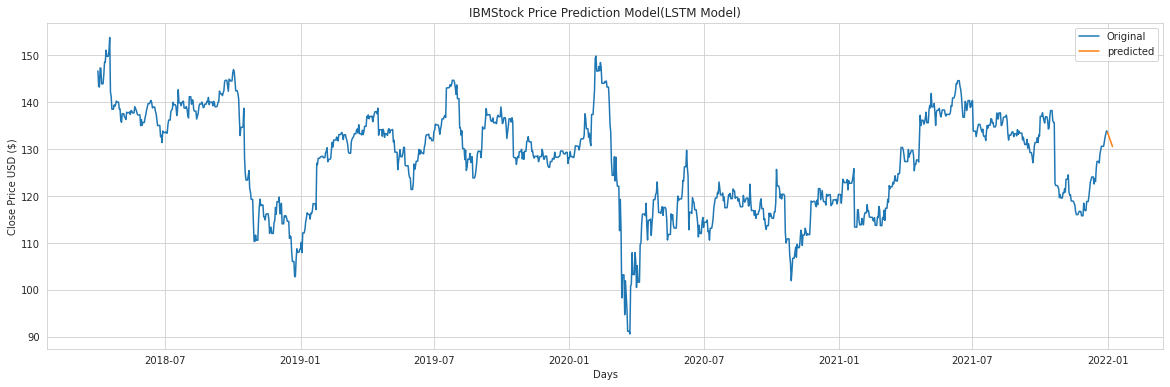

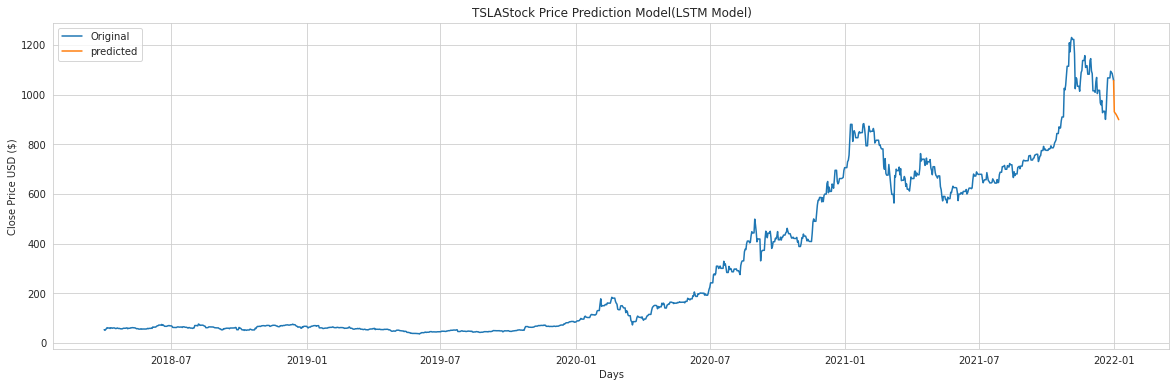

In [29]:
#visualization for next 7 days
mydates = pd.date_range(start=start,periods=future_days+1).tolist()
future_predict = []
future_predict_frame =[]
for i in range (len(IT_Companies)):
  future_predict.append(pd.Series(np.concatenate((np.array([[IT_Companies[i].iloc[-1]]]),scalers[i].inverse_transform(last_output_arr[i]))).squeeze(), index=mydates))
  future_predict_frame.append(future_predict[i].to_frame())
  future_predict_frame[i]=future_predict_frame[i].rename(columns={0: IT_Companies_names[i]})
  plt.figure(figsize=(20, 6))
  plt.title(IT_Companies_names[i]+"Stock Price Prediction Model(LSTM Model)")
  plt.xlabel("Days")
  plt.ylabel("Close Price USD ($)")
  plt.plot(IT_Companies[i]['2018-04-01':])
  plt.plot(future_predict_frame[i])
  plt.legend(["Original", "predicted"])
  plt.show()